<a href="https://colab.research.google.com/github/r-ogrady/dissertation/blob/main/c07_process_audiomnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing audio files for a word recogntion task

This was a small part of my final dissertation where I developed a novel loss function. In this notebook we process audio files that become the input for a CNN.

**Work flow**
1. Get labels from filenames and metadata
2. Load the signals and pre-process the audio (resampling etc)
3. Create spectrograms for the CNN

**Notes**
* The data is "AudioMNIST", an audioequivalent to the MNIST dataset. It can be found here https://github.com/soerenab/AudioMNIST/tree/master/data 
* This project was on neural networks so the majority of preprocessing was carried out using PyTorch (and torchvision, torchaudio)
* I used spectograms as input into my CNN to marry with other relevant work. An alternative would be MFCC

In [1]:
import matplotlib
from IPython.display import Audio
import json
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import time

import torch
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F
import torch.nn.functional as FF

In [2]:
# set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Example

In [3]:
#load a sample
my_signal,sr=torchaudio.load("data/AudioMNIST/01/0_01_0.wav")
# check dims
sr, my_signal.shape

(48000, torch.Size([1, 35877]))

In [4]:
# play a sample
Audio(my_signal, rate=sr)

# Labels

In [3]:
# get metadata from json file
metaData = json.load(open("data/AudioMNIST/audioMNIST_meta.txt"))

# check structure
list(metaData.items())[0]

('01',
 {'accent': 'german',
  'age': 30,
  'gender': 'male',
  'native speaker': 'no',
  'origin': 'Europe, Germany, Wuerzburg',
  'recordingdate': '17-06-22-11-04-28',
  'recordingroom': 'Kino'})

In [4]:
# get file list and labels
my_files=[]
my_digit=[]
my_speaker=[]
for root, dirs, files in os.walk("data/AudioMNIST"):
    for name in files:
        if name.endswith((".wav")):
            # get labels
            my_files.append(name)
            my_digit.append(name.split("_")[0])
            my_speaker.append(name.split("_")[1])

# get gender label
my_gender=[0 if metaData[speaker]["gender"]=="male" else 1 for speaker in my_speaker]

In [5]:
# check gender balance
print(f"male: {my_gender.count(0)//500}, female: {my_gender.count(1)//500}")
print(f"out of {len(list(set(my_speaker)))} speakers")

male: 48, female: 12
out of 60 speakers


In [6]:
# rebalancing
male_speakers=[]
female_speakers=[]
for i in range(len(my_files)):
    if my_gender[i]==1:
        female_speakers.append(my_speaker[i])
    else:
        male_speakers.append(my_speaker[i])

# create list of unique speakers
male_speakers=list(set(male_speakers))[:12]
female_speakers=list(set(female_speakers))
rebalanced_speakers=male_speakers+female_speakers

my_files2=[]
my_digit2=[]
my_gender2=[]
my_speaker2=[]

for i in range(len(my_speaker)):
    if my_speaker[i] in rebalanced_speakers:
        my_files2.append(my_files[i])
        my_digit2.append(my_digit[i])
        my_gender2.append(my_gender[i])
        my_speaker2.append(my_speaker[i])

# Process signals

* Downsample to 16kHz
* Crop/Pad to 1sec=16000
* Normalize to the range[-1,1]
* Spectrogtam using params to give close to 227x227

In [7]:
# load samples
my_signals=[]
my_sr=[]
t0=time.time()
for file_name in my_files2:
# get signal and sr
    signal,sr=torchaudio.load("data/AudioMNIST/"+file_name.split("_")[1]+"/"+file_name)
    my_signals.append(signal)
    my_sr.append(sr)
print(f"Took {time.time()-t0} seconds")

Took 13.679520845413208 seconds


In [8]:
# verify sample rate is unique
print(set(my_sr))

{48000}


In [9]:
# downsample from 48kHz to 16kHz
my_resampled_signals=[]

# define resampler transform
resampler=T.Resample(48000,16000)

t0=time.time()
for signal in my_signals:
    my_resampled_signals.append(resampler(signal))
print(f"Took {time.time()-t0} seconds")

Took 23.379604816436768 seconds


In [10]:
# crop and pad - all signals 1sec=16000
my_processed_signals=[]
target_len = 16000

t0=time.time()
for signal in my_resampled_signals:
    length_signal=signal.shape[1]
    # trim longer samples by slicing the second dim
    if length_signal >= target_len:
        x=signal[:,:target_len]
    # pad shorter samples with zeros at the end using torch functional
    # https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html else:
    if length_signal < target_len:
        x=FF.pad(signal,(0,target_len-length_signal))
    my_processed_signals.append(x)
print(f"Took {time.time()-t0} seconds")

Took 0.7626099586486816 seconds


In [11]:
# normalise signals - *0.95 to correct the range of output values
t0=time.time()
my_processed_signals=[signal*0.95/torch.max(torch.abs(signal)) for signal in my_processed_signals]
print(f"Took {time.time()-t0} seconds")

Took 2.9591829776763916 seconds


In [12]:
# double check audio
print(my_processed_signals[0].shape)
display(Audio(my_processed_signals[0], rate=16000))

torch.Size([1, 16000])


In [13]:
# spectrograms
# https://pytorch.org/audio/main/generated/torchaudio.transforms.Spectrogram.html

my_spectrograms=[]
# params chosen to get close to 227x227 for Alexnet
transform=T.Spectrogram(n_fft=452,
                        hop_length=70,
                        window_fn=torch.hamming_window,
                        power=1,
                        normalized=True)
t0=time.time()
for signal in my_processed_signals:
    x=transform(signal)
    # get correct dim for alexnet
    my_spectrograms.append(x[:,:227,:227])
print(f"Took {time.time()-t0} seconds")

Took 17.923956155776978 seconds


In [14]:
# plot spectrograms
# https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.amplitude_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

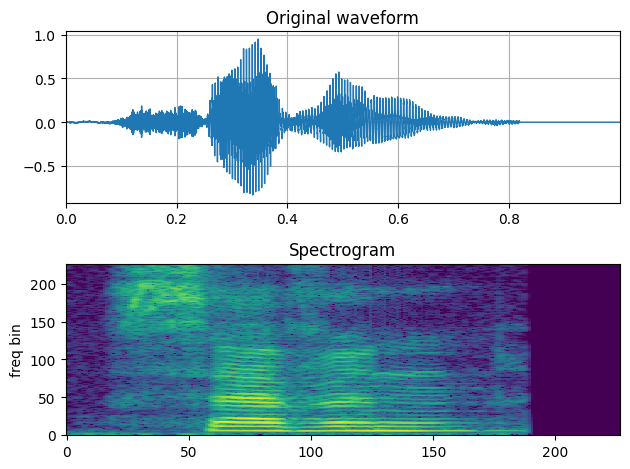

In [15]:
fig, axs = plt.subplots(2, 1)
plot_waveform(my_processed_signals[0], 16000, title="Original waveform", ax=axs[0])
plot_spectrogram(my_spectrograms[0][0], title="Spectrogram", ax=axs[1])
fig.tight_layout()

# Prepare a dataset

In [16]:
# turn labels to tensor
my_gender2=[torch.tensor(x,dtype=torch.int64) for x in my_gender2]
my_digit2=[torch.tensor(int(label),dtype=torch.int64) for label in my_digit2]
my_speaker2=[torch.tensor(int(label),dtype=torch.int64) for label in my_speaker2]

In [17]:
my_data=[my_spectrograms,my_digit2,my_speaker2,my_gender2]

In [18]:
# save data
torch.save(my_data,'data/AudioMNIST_processed/my_small_data.pt')